---
title: Sparse Observations
date: 2023-04-01
authors:
  - name: J. Emmanuel Johnson
    affiliations:
      - MEOM Lab
    roles:
      - Primary Programmer
    email: jemanjohnson34@gmail.com
license: CC-BY-4.0
keywords: NerFs, SWOT
---

In [1]:
import autoroot
import jax
import jax.numpy as jnp
import jax.scipy as jsp
import jax.random as jrandom
import numpy as np
import numba as nb
import equinox as eqx
import kernex as kex
import finitediffx as fdx
import diffrax as dfx
import xarray as xr
import metpy
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm, trange
from jaxtyping import Float, Array, PyTree, ArrayLike
import wandb
from omegaconf import OmegaConf
import hydra
from sklearn import pipeline
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from jejeqx._src.transforms.dataframe.spatial import Spherical2Cartesian
from jejeqx._src.transforms.dataframe.temporal import TimeDelta
from jejeqx._src.transforms.dataframe.scaling import MinMaxDF

sns.reset_defaults()
sns.set_context(context="talk", font_scale=0.7)
# Ensure TF does not see GPU and grab all GPU memory.
%env XLA_PYTHON_CLIENT_PREALLOCATE=false
jax.config.update("jax_enable_x64", False)

%matplotlib inline
%load_ext autoreload
%autoreload 2

env: XLA_PYTHON_CLIENT_PREALLOCATE=false


## Recap Formulation

We are interested in learning non-linear functions $\boldsymbol{f}$.

$$
\begin{aligned}
\boldsymbol{f}(\mathbf{x}) &=
\mathbf{w}^\top\boldsymbol{\phi}(\mathbf{x})+\mathbf{b}
\end{aligned}
$$

where the $\boldsymbol{\phi}(\cdot)$ is a basis function. Neural Fields typically try to learn this basis funciton via a series of composite functions of the form

$$
\boldsymbol{\phi}(\mathbf{x}) =
\boldsymbol{\phi}_L\circ\boldsymbol{\phi}_{L-1}
\circ\cdots\circ
\boldsymbol{\phi}_2\circ\boldsymbol{\phi}_{1}(\mathbf{x})
$$

## Problems

Here, we will demonstrate a problem that a naive network has.

## Sparse Observations

In the previous examples, we were demonstrating how NerFs perform when we have some clean simulation. 
However, in many real problems, we do not have access to such clean

For this example, we are going to look at the case when we have very sparse observations: as in the case with satellite altimetry data like SWOT. In this case

In [2]:
# !wget -nc "https://s3.us-east-1.wasabisys.com/melody/osse_data/data/gridded_data_swot_wocorr/dataset_nadir_0d_swot.nc"

In [3]:
from pathlib import Path

In [4]:
Path("/gpfswork/rech/cli/uvo53rl/projects/jejeqx/data/natl60/dataset_nadir_0d_swot.nc").is_file()

True

In [16]:
from dataclasses import dataclass, field
from typing import List, Dict

@dataclass
class Subset:
    _target_: str = "builtins.slice"
    _args_: List = field(default_factory=lambda :["2013-01-01", "2013-01-10"])

files = [
    # "/gpfswork/rech/yrf/commun/data_challenges/dc20a_osse/work_eman/ml_ready/swot1nadir5.nc",
    "/gpfswork/rech/yrf/commun/data_challenges/dc20a_osse/work_eman/ml_ready/nadir4.nc",
]

@dataclass
class SSHDM:
    _target_: str = "jejeqx._src.datamodules.coords.AlongTrackDM"
    paths: List[str] = field(default_factory=lambda : files)
    batch_size: int = 5_000
    shuffle: bool = True
    train_size: float = 0.90
    # subset_size: float = None
    spatial_coords: List = field(default_factory=lambda : ["lat", "lon"])
    temporal_coords: List = field(default_factory=lambda: ["time"])
    variables: List = field(default_factory=lambda : ["ssh_obs"])
    
# spatial transform
spatial_transforms = Pipeline([
    ("cartesian3d", Spherical2Cartesian(radius=1.0, units="degrees")),
    ("spatialminmax", MinMaxDF(["x", "y", "z"], -1, 1)),
])

temporal_transforms = Pipeline([
    # ("timedelta", TimeDelta("2012-10-01", 1, "s")),
    ("timeminmax", MinMaxDF(["time"], -1, 1)),
])


In [24]:
# select = {"time": slice("2012-10-22", "2012-11-22")}
select = {"time": slice("2012-10-01", "2012-12-02")}

config_dm = OmegaConf.structured(SSHDM())

dm = hydra.utils.instantiate(
    config_dm,
    select=select,
    spatial_transform=spatial_transforms,
    temporal_transform=temporal_transforms,
)

dm.setup()


init = dm.ds_train[:32]
x_init, t_init, y_init = init["spatial"], init["temporal"], init["data"]
x_init.min(), x_init.max(), x_init.shape, t_init.min(), t_init.max(), t_init.shape

Index(['lat', 'lon'], dtype='object') Index(['time'], dtype='object') Index(['ssh_obs'], dtype='object')


(-0.967476650713305,
 0.9292991278019631,
 (32, 3),
 -0.931211407626165,
 0.981075131157354,
 (32, 1))

In [25]:
len(dm.ds_train)

30946

In [26]:
xrda_obs = dm.load_xrds()

In [15]:
# fig, ax = plt.subplots(ncols=1, figsize=(5,4))

# xrda_obs.ssh_obs.isel(time=1).plot.pcolormesh(ax=ax, cmap="viridis")
# ax.set(title="Original")

# plt.tight_layout()
# plt.show()

In [16]:
# import geoviews as gv
# import geoviews.feature as gf
# from cartopy import crs

# gv.extension('bokeh', 'matplotlib')

In [17]:
# xrda_obs

In [18]:
# dataset = gv.Dataset(xrda_obs)
# ensemble1 = dataset.to(gv.Image, ['lon', 'lat'], "ssh_obs")
# gv.output(ensemble1.opts(cmap='viridis', colorbar=True, fig_size=200, backend='matplotlib') * gf.coastline(),
#           backend='matplotlib')

In [19]:
# lr = 5e-3
# num_epochs = 5_000
# num_steps_per_epoch = len(dm.ds_train)

# @dataclass
# class FoxDataModule:
#     _target_: str = "jejeqx._src.datamodules.image.ImageFox"
#     batch_size: int = 10_000
#     train_size: float = 0.5
#     shuffle: bool = False
#     split_method: str = "even"
#     resize: int = 4
    
# @dataclass
# class Training:
#     num_epochs: int = 2_000

# @dataclass
# class Model:
#     _target_: str = "jejeqx._src.nets.nerfs.siren.SirenNet"
#     in_size: int = 2
#     out_size: int = 3
#     width_size: int = 128
#     depth: int = 5

# @dataclass
# class Optimizer:
#     _target_: str = "optax.adam"
#     learning_rate: float = lr
    
# @dataclass
# class Scheduler:
#     _target_: str = "optax.warmup_cosine_decay_schedule"
#     init_value: float = 0.0
#     peak_value: float = lr
#     warmup_steps: int = 100
#     decay_steps: int = int(num_epochs * num_steps_per_epoch)
#     end_value: float = 0.01 * lr
    
# @dataclass
# class Config:
#     datamodule: FoxDataModule = FoxDataModule()
#     model: Model = Model()
#     optimizer: Optimizer = Optimizer()
#     scheduler: Scheduler = Scheduler()
#     num_epochs: int = 2_000

In [20]:
# import optax

# config = Config()
# config = OmegaConf.structured(Config())

# # initialize datamodule
# dm = hydra.utils.instantiate(config.datamodule)

# dm.setup()


# # initialize optimizer
# optimizer = hydra.utils.instantiate(config.optimizer)

# # initialize scheduler
# num_steps_per_epoch = len(dm.ds_train)
# decay_steps = int(num_steps_per_epoch * config.num_epochs)
# schedule_fn = hydra.utils.instantiate(config.scheduler, decay_steps=decay_steps)

# # initialize optimizer + scheduler
# optimizer = optax.chain(optimizer, optax.scale_by_schedule(schedule_fn))



In [21]:
# ibatch = next(iter(dm.train_dataloader()))

# print(ibatch[0].shape, ibatch[1].shape, type(ibatch[0]))

## Model

The input data is a coordinate vector, $\mathbf{x}_\phi$, of the image coordinates.

$$
\mathbf{x}_\phi \in \mathbb{R}^{D_\phi}
$$

where $D_\phi = [\text{x}, \text{y}]$. So we are interested in learning a function, $\boldsymbol{f}$, such that we can input a coordinate vector and output a scaler/vector value of the pixel value.

$$
\mathbf{u} = \boldsymbol{f}(\mathbf{x}_\phi; \boldsymbol{\theta})
$$

### SIREN Layer

$$
\boldsymbol{\phi}^{(\ell)}(\mathbf{x}) = \sin
\left(
\omega^{(\ell)}\left(
\mathbf{w}^{(\ell)}\mathbf{x} + \mathbf{b}^{(\ell)} + \mathbf{s}^{(\ell)}
\right)\right)
$$

where $\mathbf{s}$ is the modulation

$$
\mathbf{s}^{(\ell)} = \mathbf{w}_z^{(\ell)}\mathbf{z} + \mathbf{b}_z^{(\ell)}
$$

In [22]:
!ls /gpfswork/rech/cli/uvo53rl/checkpoints/nerfs/siren_nadir4

checkpoint_model.ckpt  config.pkl


In [8]:
!ls /gpfswork/rech/cli/uvo53rl/checkpoints/nerfs/siren/nadir4/scratch

checkpoint_model.ckpt  config.pkl


In [9]:
import joblib

model_config_file = "/gpfswork/rech/cli/uvo53rl/checkpoints/nerfs/siren/nadir4/scratch/config.pkl"
checkpoint_file = "/gpfswork/rech/cli/uvo53rl/checkpoints/nerfs/siren/nadir4/scratch/checkpoint_model.ckpt"

old_config = joblib.load(model_config_file)

model = hydra.utils.instantiate(old_config["model"])

In [10]:
# from jejeqx._src.nets.nerfs.ffn import RFFLayer

# model_name = "rff"


# model = eqx.nn.Sequential(
#     [RFFLayer(in_dim=4, num_features=256, out_dim=256, key=jrandom.PRNGKey(42)),
#      RFFLayer(in_dim=256, num_features=256, out_dim=256, key=jrandom.PRNGKey(123)),
#      RFFLayer(in_dim=256, num_features=256, out_dim=256, key=jrandom.PRNGKey(23)),
#      RFFLayer(in_dim=256, num_features=256, out_dim=256, key=jrandom.PRNGKey(81)),
#      RFFLayer(in_dim=256, num_features=256, out_dim=1, key=jrandom.PRNGKey(32)),
#     ]
# )
# # check output of models
# out = jax.vmap(model)(jnp.hstack([x_init,t_init]))

# assert out.shape == y_init.shape

In [11]:
# model_name = "siren"

# @dataclass
# class Key:
#     _target_: str = "jax.random.PRNGKey"
#     seed: int = 123
    

# @dataclass
# class SirenBasis:
#     _target_: str = "jejeqx._src.nets.nerfs.siren.SirenNet"
#     in_size: int = 4
#     out_size: int = 256
#     width_size: int = 256
#     depth: int = 5
#     key: Key = Key()
    
# @dataclass
# class LinearModel:
#     _target_: str = "equinox.nn.Linear"
#     in_features: int = 256
#     out_features: int = 1
#     use_bias: bool = True
#     key: Key = Key()
    
# @dataclass
# class NerFModel:
#     _target_: str = "jejeqx._src.nets.nerfs.base.NerF"
#     # basis_net: RFFBasis = RFFBasis()
#     basis_net: SirenBasis = SirenBasis()
#     network: LinearModel = LinearModel()
    
# # initialize model
# model_config = OmegaConf.structured(NerFModel())

# model = hydra.utils.instantiate(model_config)

# # check output of models
# out = jax.vmap(model)(jnp.hstack([x_init,t_init]))

# assert out.shape == y_init.shape

In [18]:
# model

## Optimizer (+ Learning Rate)

For this, we will use a simple adam optimizer with a `learning_rate` of 1e-4. From many studies, it appears that a lower learning rate works well with this methods because there is a lot of data. In addition, a bigger `batch_size` is also desireable. We will set the `num_epochs` to `1_000` which should be good enough for a single image. Obviously more epochs and a better learning rate scheduler would result in better results but this will be sufficient for this demo.

In [12]:
import optax

num_epochs = 6_000

@dataclass
class Optimizer:
    _target_: str = "optax.adamw"
    learning_rate: float = 1e-5
# @dataclass
# class Scheduler:
#     _target_: str = "optax.warmup_exponential_decay_schedule"
#     init_value: float = 0.0
#     peak_value: float = 1e-2
#     warmup_steps: int = 100
#     end_value: float = 1e-5
#     decay_rate: float = 0.1

# FINETUNE!
@dataclass
class Scheduler:
    _target_: str = "optax.warmup_cosine_decay_schedule"
    init_value: float = 0.0
    peak_value: float = 1e-2
    warmup_steps: int = 500
    end_value: float = 1e-6
    
scheduler_config = OmegaConf.structured(Scheduler())

In [13]:
optim_config = OmegaConf.structured(Optimizer())

optimizer = hydra.utils.instantiate(optim_config)

# num_steps_per_epoch = len(dm.ds_train)

# scheduler = hydra.utils.instantiate(
#     scheduler_config, 
#     decay_steps=int(num_epochs * num_steps_per_epoch)
# )

# optimizer = optax.chain(optimizer, optax.scale_by_schedule(scheduler))

## Trainer Module

In [27]:
import glob
import os
from pathlib import Path

from jejeqx._src.trainers.base import TrainerModule
from jejeqx._src.trainers.callbacks import wandb_model_artifact
from jejeqx._src.losses import psnr


class RegressorTrainer(TrainerModule):
    def __init__(self,
                 model,
                 optimizer,
                 **kwargs):
        super().__init__(
            model=model, 
            optimizer=optimizer, 
            pl_logger=None,
            **kwargs
        )
        
    @property
    def model(self):
        return self.state.params

    @property
    def model_batch(self):
        return jax.vmap(self.state.params, in_axes=(0,0))

    def create_functions(self):

        @eqx.filter_value_and_grad
        def mse_loss(model, batch):
            x, t, y = batch["spatial"], batch["temporal"], batch["data"]
            # pred = jax.vmap(model, in_axes=(0,0))(x, t)
            pred = jax.vmap(model)(jnp.hstack([x, t]))
            loss = jnp.mean((y - pred)**2)
            return loss
        
        def train_step(state, batch):
            
            loss, grads = mse_loss(state.params, batch)
            state = state.update_state(state, grads)
            psnr_loss = psnr(loss) 
            metrics = {"loss": loss, "psnr": psnr_loss}
            return state, loss, metrics

        def eval_step(model, batch):
            loss, _ = mse_loss(model, batch)
            psnr_loss = psnr(loss) 
            return {"loss": loss, "psnr": psnr_loss}
        
        def test_step(model, batch):
            x, t, y = batch["spatial"], batch["temporal"], batch["data"]
            pred = jax.vmap(model)(jnp.hstack([x, t]))
            loss, _ = mse_loss(model, batch)
            psnr_loss = psnr(loss)
            return pred, {"loss": loss, "psnr": psnr_loss}
        
        def predict_step(model, batch):
            x, t = batch["spatial"], batch["temporal"]
            pred = jax.vmap(model)(jnp.hstack([x, t]))
            return pred

        return train_step, eval_step, test_step, predict_step
    
    def on_training_end(self,):
        
        if self.pl_logger:
            save_dir = Path(self.log_dir).joinpath(self.save_name)
            self.save_model(save_dir)
            wandb_model_artifact(self)
            self.pl_logger.finalize("success")
        
        


In [28]:
seed = 123
debug = False
enable_progress_bar = False
log_dir = "./"

trainer = RegressorTrainer(
    model, 
    optimizer, 
    seed=seed, 
    debug=debug, 
    enable_progress_bar=enable_progress_bar,
    log_dir=log_dir
)

train_more = True
save_more = True

In [29]:
%%time

out, metrics = trainer.test_model(dm.test_dataloader())
metrics

CPU times: user 1.52 s, sys: 10.3 ms, total: 1.53 s
Wall time: 1 s


{'loss': 0.34897580742836, 'psnr': 3.795210838317871}

In [30]:
trainer.load_model(checkpoint_file)

In [31]:
%%time

out, metrics = trainer.test_model(dm.test_dataloader())
metrics

CPU times: user 132 ms, sys: 2.03 ms, total: 134 ms
Wall time: 129 ms


{'loss': 6.606836541322991e-05, 'psnr': 89.31793212890625}

In [32]:
# %%time

# metrics = trainer.train_model(dm, num_epochs=num_epochs)

In [33]:
%%time

out, metrics = trainer.test_model(dm.test_dataloader())
metrics

CPU times: user 130 ms, sys: 2.3 ms, total: 132 ms
Wall time: 127 ms


{'loss': 6.606836541322991e-05, 'psnr': 89.31793212890625}

## Evaluation

We will predict the whole dataset at the full resolution available for the same time period.

`01-June-2013 :--> 15-June-2013`

In [36]:
from dataclasses import dataclass, field
from typing import List, Dict


@dataclass
class SSHDMEVAL:
    _target_: str = "jejeqx._src.datamodules.coords.EvalCoordDM"
    paths: str = "/gpfswork/rech/yrf/commun/data_challenges/dc20a_osse/test/dc_ref/NATL60-CJM165_GULFSTREAM*"
    batch_size: int = 10_000
    shuffle: bool = False
    train_size: float = 0.80
    decode_times: bool = True
    evaluation: bool = True
    spatial_coords: List = field(default_factory=lambda : ["lat", "lon"])
    temporal_coords: List = field(default_factory=lambda: ["time"])
    variables: List = field(default_factory=lambda : ["sossheig"])
    coarsen: Dict = field(default_factory=lambda : {"lon": 2, "lat": 2})
    resample: str = "1D"

In [37]:
%%time

# select = {"time": slice("2012-10-22", "2012-11-22")}
select = {"time": slice("2012-10-22", "2012-12-02")}

config_dm = OmegaConf.structured(SSHDMEVAL())

dm_eval = hydra.utils.instantiate(
    config_dm,
    select=select,
    spatial_transform=dm.spatial_transform,
    temporal_transform=dm.temporal_transform
)

dm_eval.setup()

Index(['lat', 'lon'], dtype='object') Index(['time'], dtype='object') Index(['sossheig'], dtype='object')
CPU times: user 19.3 s, sys: 3.04 s, total: 22.3 s
Wall time: 32.2 s


In [38]:
print(f"Num Points: {len(dm_eval.ds_test):,}")

Num Points: 3,780,000


In [39]:
%%time

xrda = dm_eval.load_xrds()

CPU times: user 19.2 s, sys: 2.67 s, total: 21.9 s
Wall time: 15.9 s


In [40]:
%%time

out, metrics = trainer.test_model(dm_eval.test_dataloader())
metrics

CPU times: user 15.2 s, sys: 89.5 ms, total: 15.2 s
Wall time: 14.8 s


{'loss': 0.005919570103287697, 'psnr': 46.78287124633789}

In [41]:
xrda["ssh_rff"] = dm_eval.data_to_df(out).to_xarray().sossheig

In [43]:
import common_utils as cutils

In [44]:
ds_rff = cutils.calculate_physical_quantities(xrda.ssh_rff)
ds_natl60 = cutils.calculate_physical_quantities(xrda.sossheig)

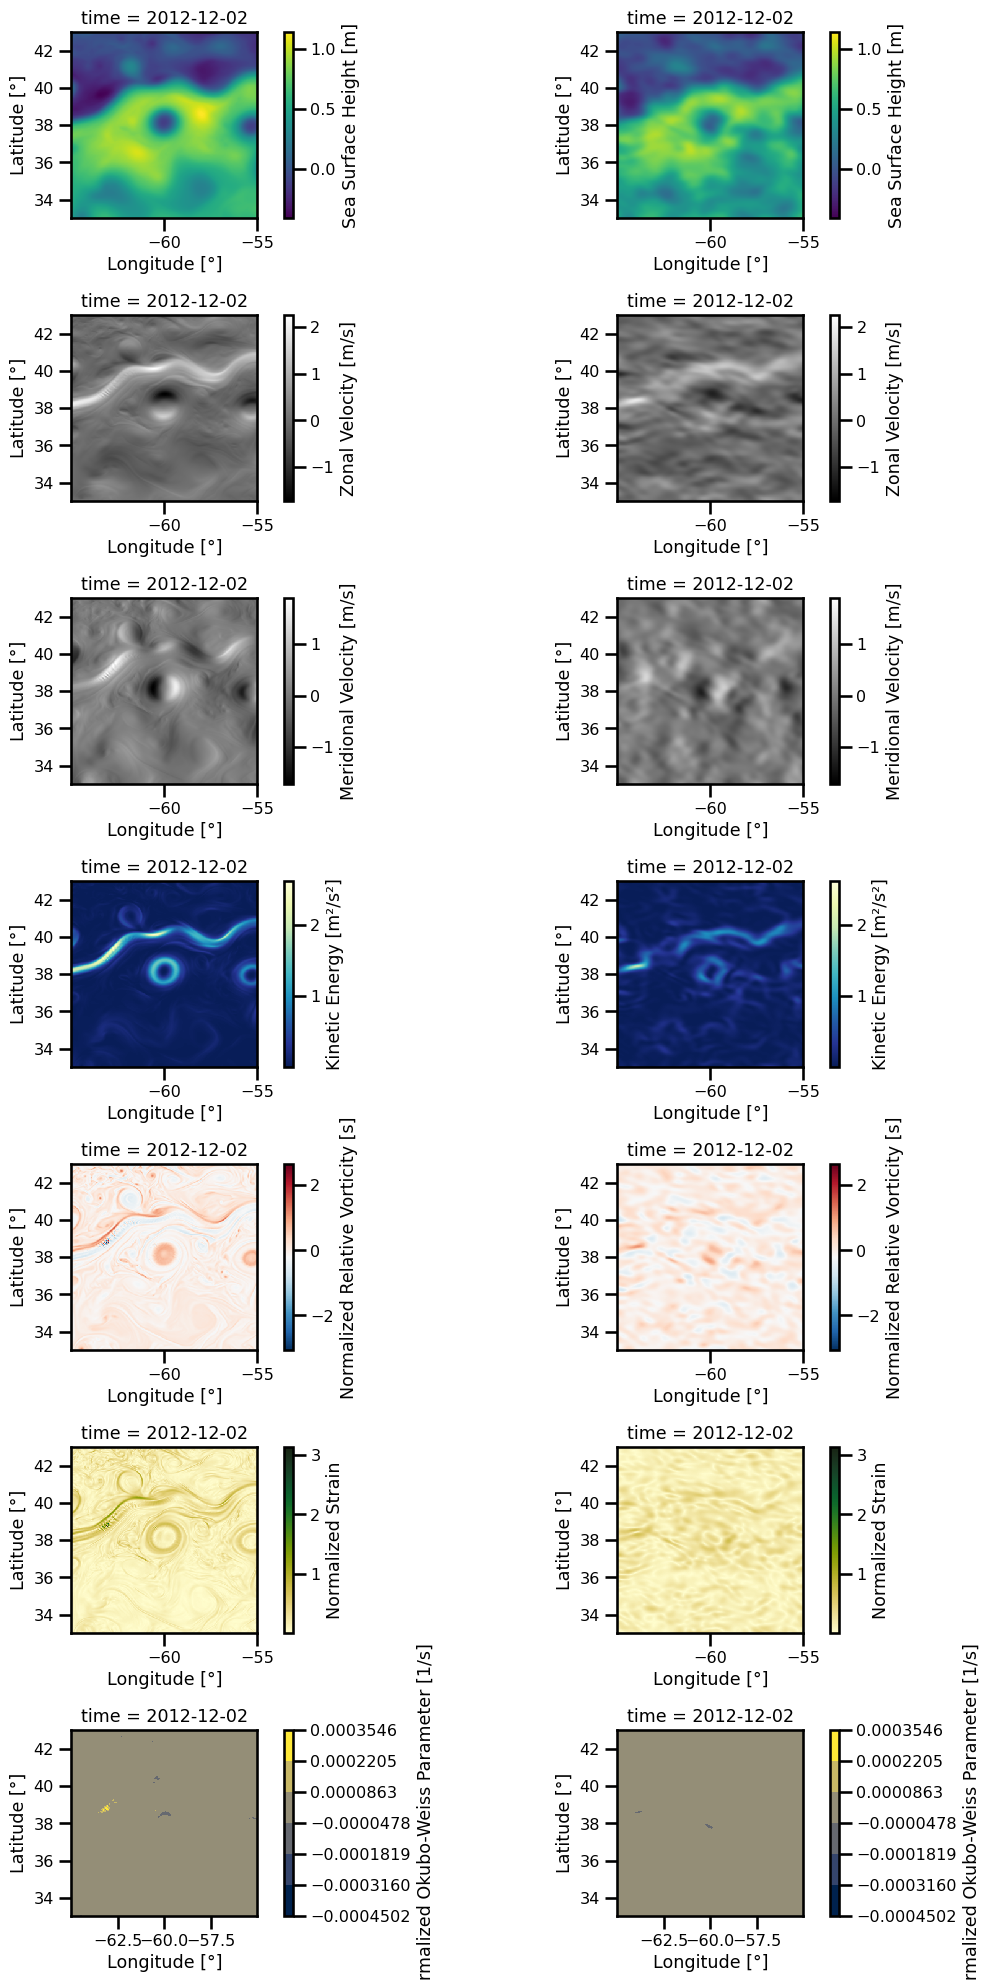

In [45]:
fig, ax = cutils.plot_analysis_vars([
    ds_natl60.isel(time=-1),
    ds_rff.isel(time=-1),]
)
plt.show()

In [46]:
ds_psd_natl60 = cutils.calculate_isotropic_psd(ds_natl60)
ds_psd_rff = cutils.calculate_isotropic_psd(ds_rff)


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

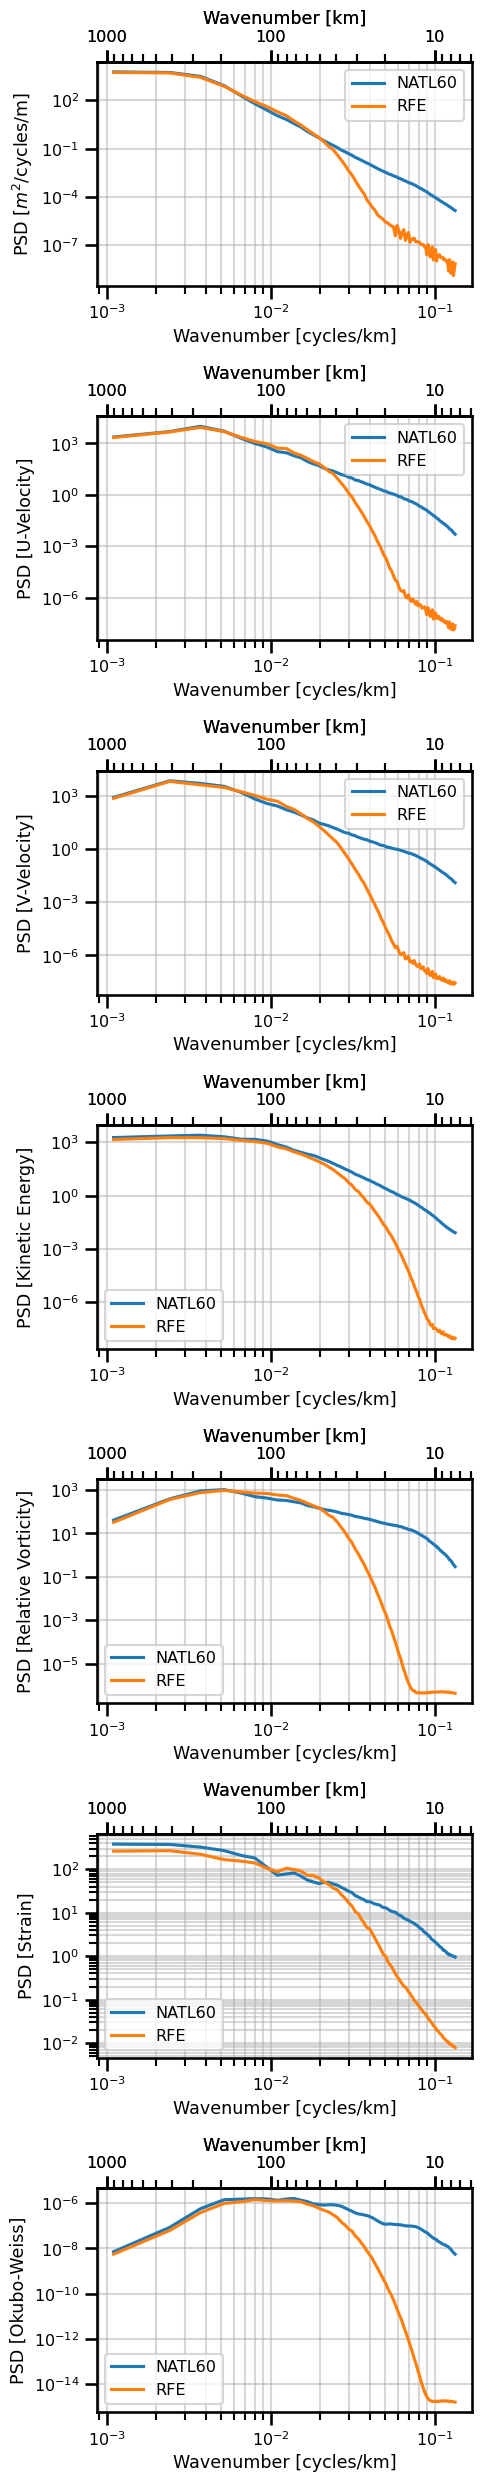

In [47]:
fig, ax = cutils.plot_analysis_psd_iso(
    [ds_psd_natl60, ds_psd_rff,],
    ["NATL60","RFE", ]
)
plt.show()

In [56]:
ds_psd_scores = cutils.calculate_isotropic_psd_score(ds_rff, ds_natl60)

  0%|          | 0/4 [00:00<?, ?it/s]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


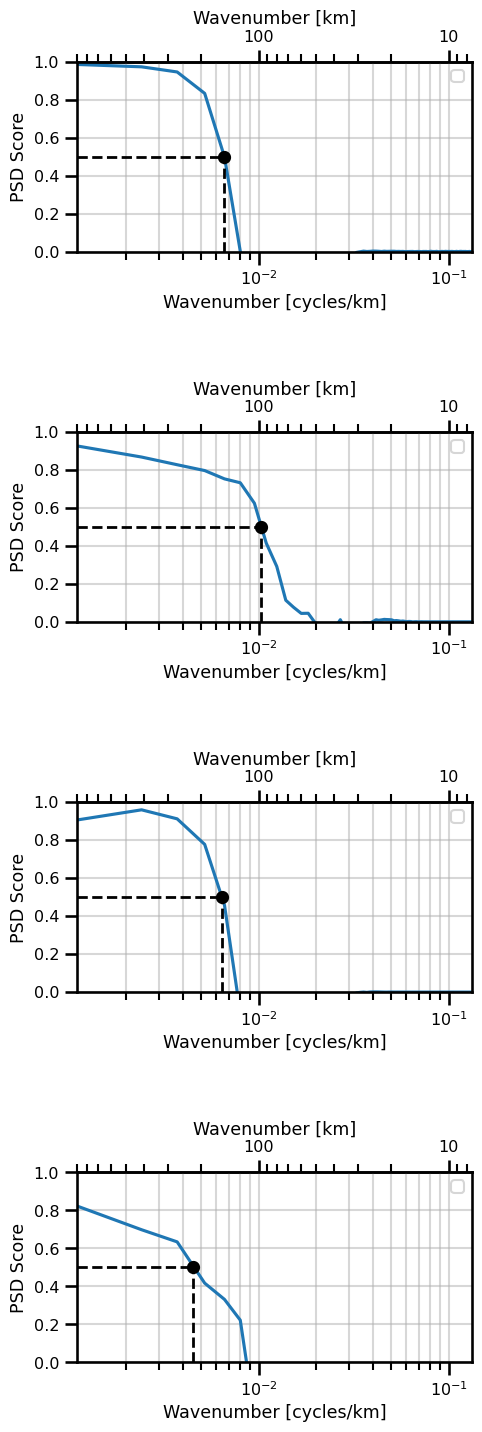

In [57]:
cutils.plot_analysis_psd_iso_score([ds_psd_scores], ["SIREN"], ["k"])
plt.show()

In [60]:
for ivar in ds_psd_scores:
    resolved_spatial_scale = ds_psd_scores[ivar].attrs["resolved_scale_space"] / 1e3 
    print(f"Wavelength [km]: {resolved_spatial_scale:.2f} [{ivar.upper()}]")
    print(f"Wavelength [degree]: {resolved_spatial_scale/111:.2f} [{ivar.upper()}]")

Wavelength [km]: 151.53 [SSH]
Wavelength [degree]: 1.37 [SSH]
Wavelength [km]: 96.93 [KE]
Wavelength [degree]: 0.87 [KE]
Wavelength [km]: 156.72 [VORT_R]
Wavelength [degree]: 1.41 [VORT_R]
Wavelength [km]: 221.38 [STRAIN]
Wavelength [degree]: 1.99 [STRAIN]


In [61]:
ds_psd_natl60 = cutils.calculate_spacetime_psd(ds_natl60)
ds_psd_rff = cutils.calculate_spacetime_psd(ds_rff)


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

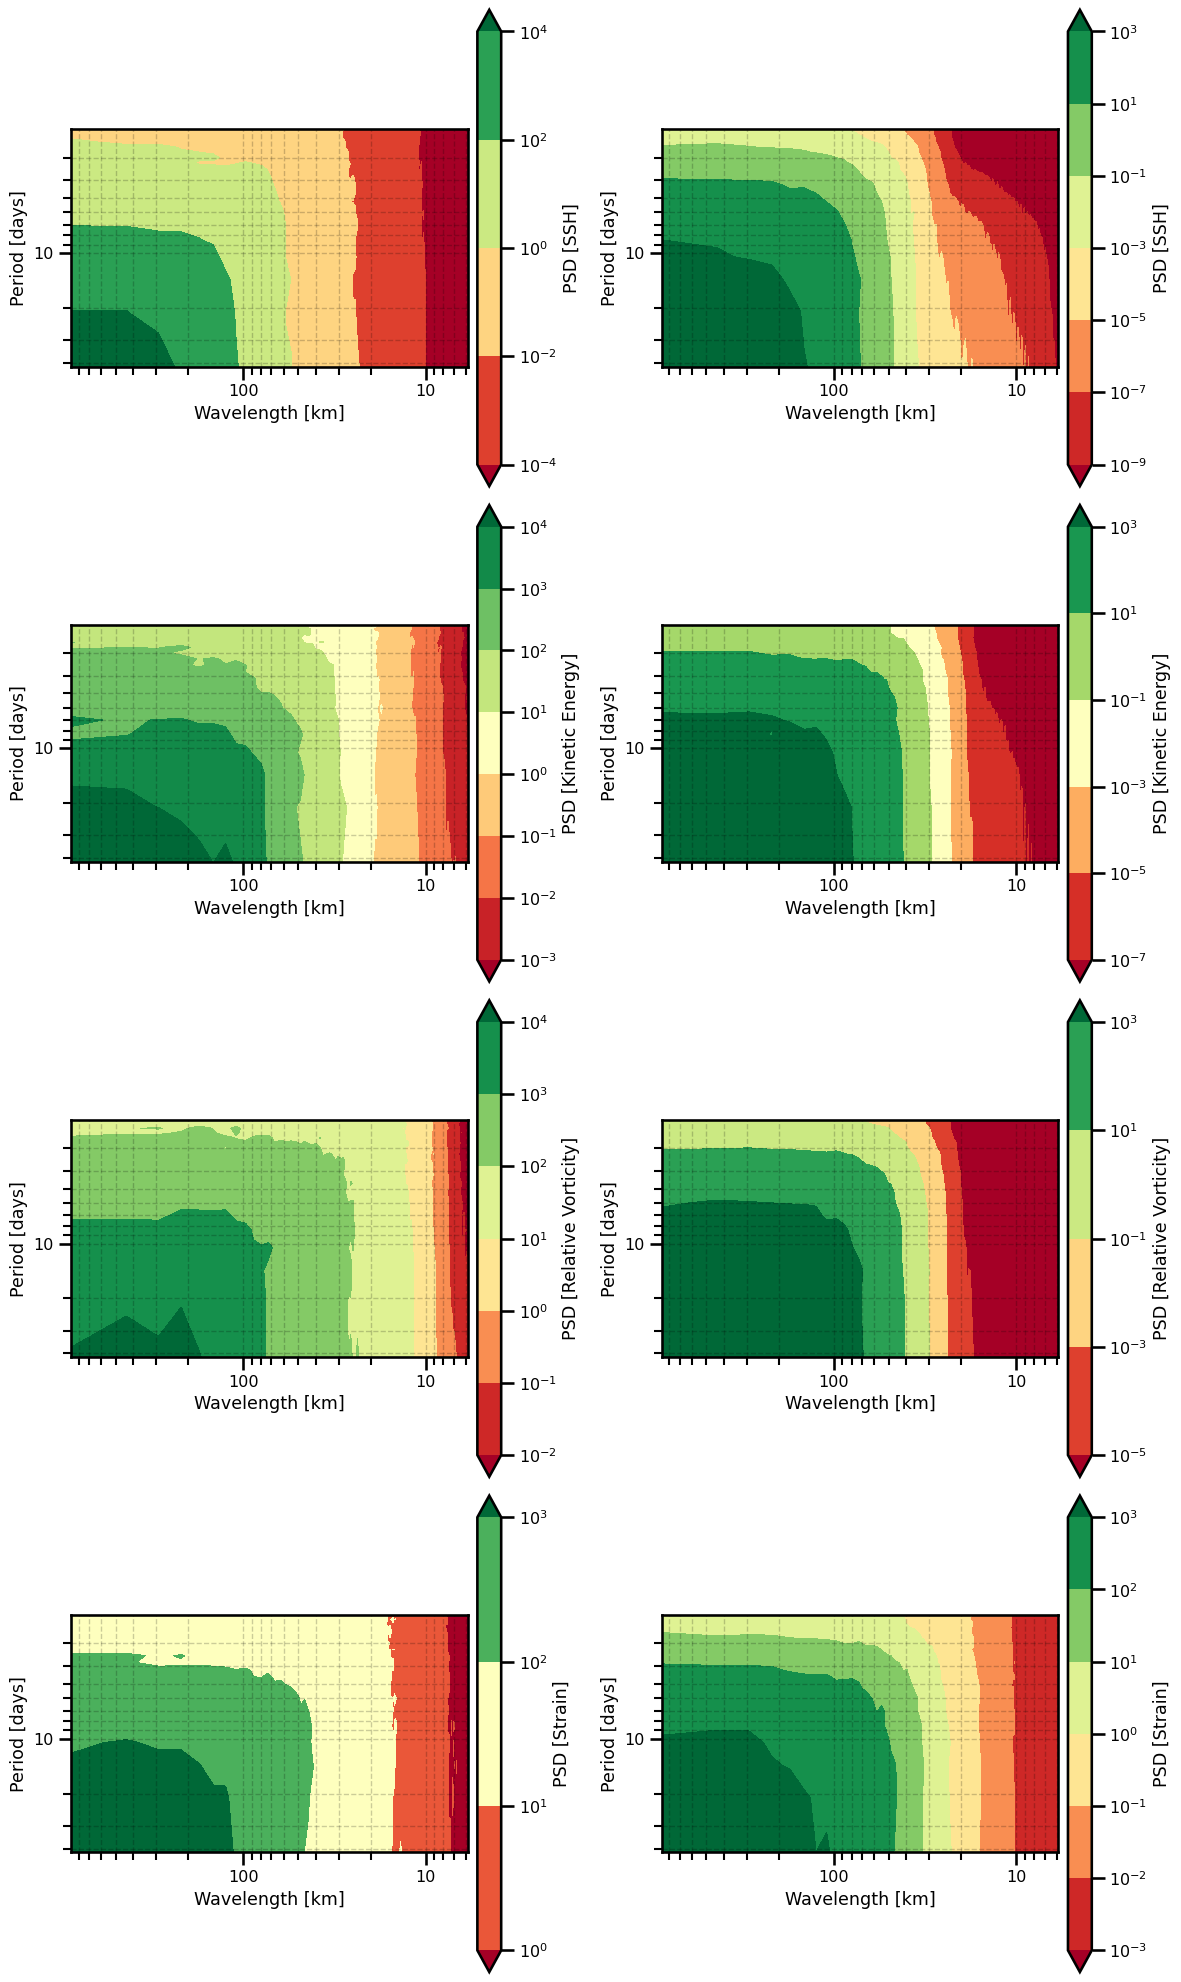

In [62]:
fig, ax = cutils.plot_analysis_psd_spacetime(
    [ds_psd_natl60, ds_psd_rff,],
    ["NATL60","RFE", ]
)
plt.show()

In [63]:
ds_psd_rff = cutils.calculate_spacetime_psd_score(ds_rff, ds_natl60)

  0%|          | 0/4 [00:00<?, ?it/s]

In [64]:
for ivar in ds_psd_rff:
    resolved_spatial_scale = ds_psd_rff[ivar].attrs["resolved_scale_space"] / 1e3 
    print(f"Resolved Scale [km]: {resolved_spatial_scale:.2f} [{ivar.upper()}]")
    resolved_temporal_scale = ds_psd_rff[ivar].attrs["resolved_scale_time"]
    print(f"Resolved Scale [days]: {resolved_temporal_scale:.2f}  [{ivar.upper()}]")

Resolved Scale [km]: 163.65 [SSH]
Resolved Scale [days]: 13.41  [SSH]
Resolved Scale [km]: 97.27 [KE]
Resolved Scale [days]: 13.27  [KE]
Resolved Scale [km]: 250.42 [VORT_R]
Resolved Scale [days]: 24.98  [VORT_R]
Resolved Scale [km]: 279.23 [STRAIN]
Resolved Scale [days]: 38.58  [STRAIN]


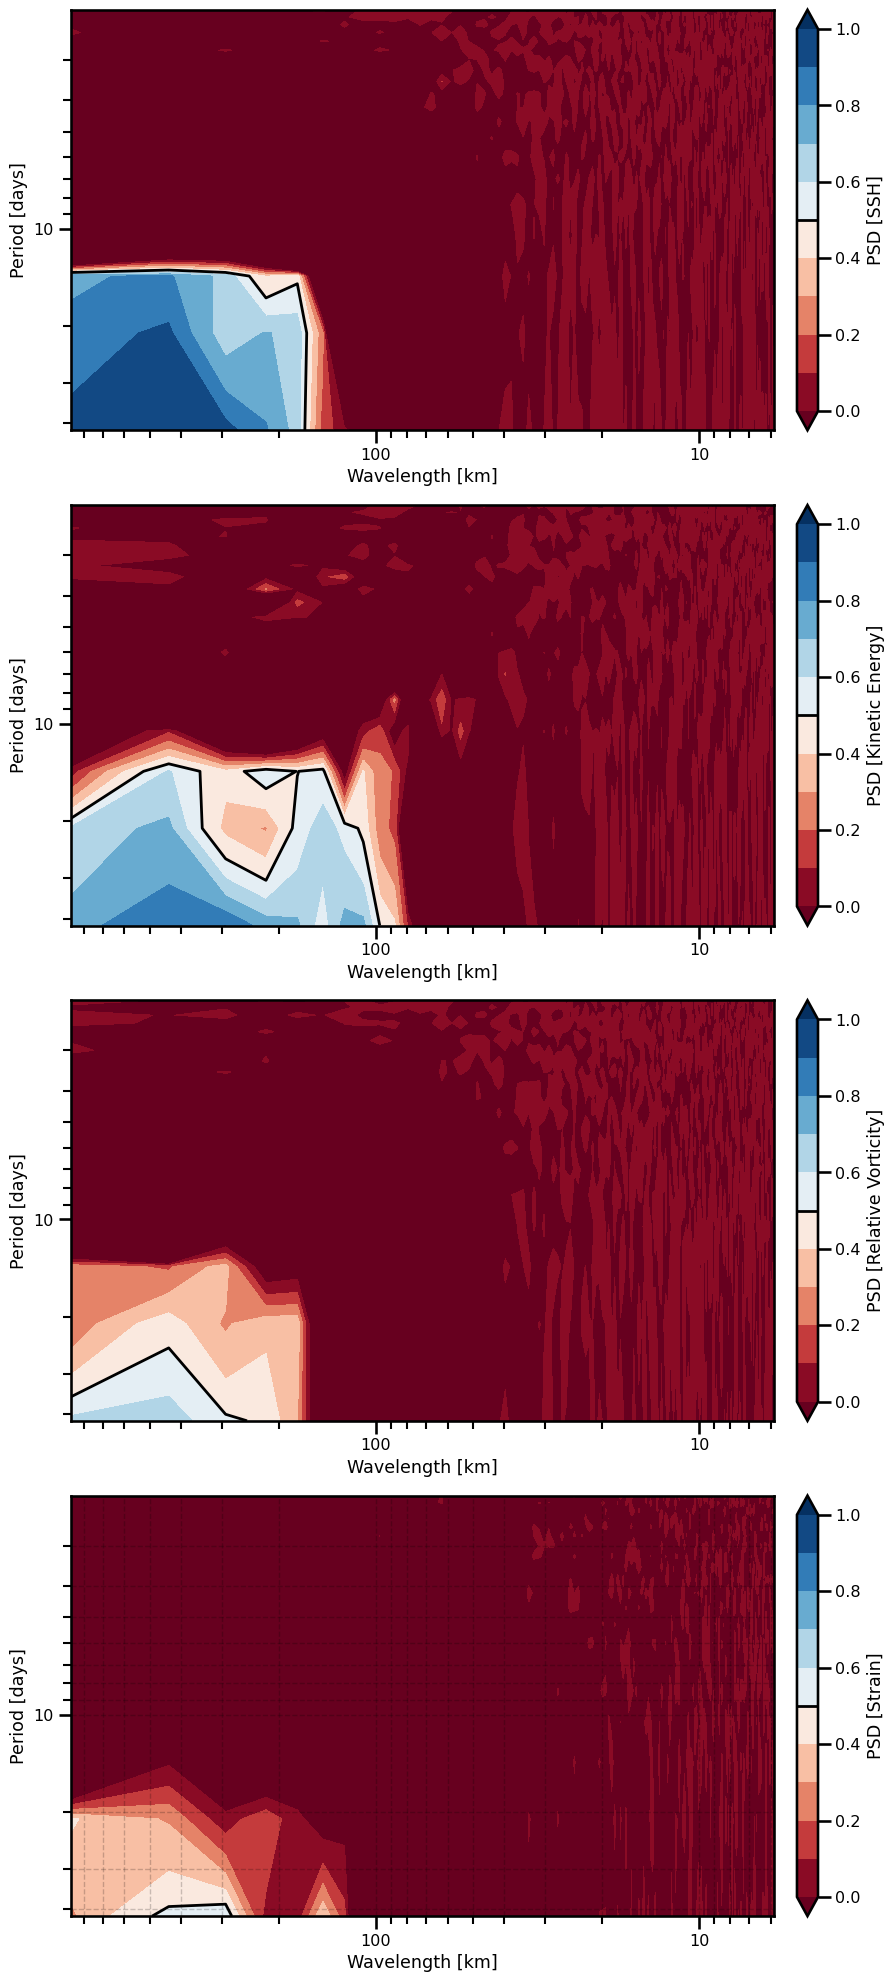

In [65]:
_ = cutils.plot_analysis_psd_spacetime_score(
    [ds_psd_rff], ["rff"]
)